In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import json
import requests
import pandas_ta as ta

In [2]:


def get_dataframe(ticker, start, end):
    response = requests.get('https://api.senticrypt.com/v2/all.json')
    if response.status_code == 200:
        data = response.json()
        print(data)
    else:
        print(f"Error: {response.status_code}")


    df = pd.DataFrame(data)
    df = df.iloc[::-1]
    df['Date'] = pd.to_datetime(df['date'])
    # df.drop(columns=['date'], inplace = True)
    
    

    
    data1 = yf.download(tickers = ticker, start = start,end = end)
    data = pd.merge(data1, df, on = 'Date')
    data.drop(columns=['price','volume','score1','score2','score3','count',	'sum'], inplace = True)
    data['RSI']=ta.rsi(data.Close, length=15)
    data['EMAF']=ta.ema(data.Close, length=20)
    data['EMAM']=ta.ema(data.Close, length=100)
    data['EMAS']=ta.ema(data.Close, length=150)

    data['Target'] = data['Adj Close']-data.Open
    data['Target'] = data['Target'].shift(-1)

    data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]

    data['TargetNextClose'] = data['Adj Close'].shift(-1)

    data.dropna(inplace=True)
    data.reset_index(inplace = True)
    data.drop(['Volume', 'Close','Date','index'], axis=1, inplace=True)
    data_set = data.iloc[:, 0:12]
    pd.set_option('display.max_columns', None)
    
    return data_set

In [3]:
# from get_data import get_dataframe
result = get_dataframe('BTC-USD', '2019-04-15', str(pd.Timestamp.today()).split(' ')[0])
result.to_csv('btc_data_with_date.csv', index=False)

[{'date': '2024-03-11', 'price': 70000.0, 'volume': 10594.0, 'score1': -0.5201, 'score2': -0.0276, 'score3': 0.0305, 'count': 24, 'mean': -0.1724, 'sum': -4.1369}, {'date': '2024-03-10', 'price': 68450.0, 'volume': 866.0, 'score1': -0.2803, 'score2': 0.0584, 'score3': 0.1839, 'count': 114, 'mean': -0.0127, 'sum': -1.4446}, {'date': '2024-03-09', 'price': 68450.0, 'volume': 866.0, 'score1': -0.357, 'score2': 0.0851, 'score3': 0.2526, 'count': 120, 'mean': -0.0064, 'sum': -0.7716}, {'date': '2024-03-08', 'price': 67066.0, 'volume': 240.0, 'score1': -0.1084, 'score2': 0.1395, 'score3': 0.2412, 'count': 162, 'mean': 0.0908, 'sum': 14.7016}, {'date': '2024-03-07', 'price': 68098.0, 'volume': 22228.0, 'score1': -0.253, 'score2': 0.0504, 'score3': 0.2136, 'count': 153, 'mean': 0.0037, 'sum': 0.5591}, {'date': '2024-03-06', 'price': 67654.0, 'volume': 34336.0, 'score1': -0.3672, 'score2': 0.1622, 'score3': 0.2023, 'count': 111, 'mean': -0.0009, 'sum': -0.0993}, {'date': '2024-03-05', 'price': 

[*********************100%%**********************]  1 of 1 completed


In [4]:
from prophet import Prophet
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

In [5]:

df = pd.read_csv('btc_data_with_date.csv')
df['TargetNextClose'] = df['Adj Close'].shift(-1)
df_train= df[:-90]
# df=df_train
df_test = df[-90:]


In [81]:
df

,Open,High,Low,Adj Close,date,mean,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
0,10123.035156,10215.948242,9980.776367,10178.372070,2019-09-11,0.1725,47.342426,10294.158326,9692.104233,9123.295244,233.307617,1,10410.126953
1,10176.819336,10442.253906,10099.242188,10410.126953,2019-09-12,0.2258,51.280170,10305.202957,9706.322505,9140.339373,-54.815430,0,10360.546875
2,10415.362305,10441.489258,10226.596680,10360.546875,2019-09-13,0.0590,50.416005,10310.473807,9719.277443,9156.501062,12.645508,1,10358.048828
3,10345.403320,10422.133789,10291.694336,10358.048828,2019-09-14,0.2153,50.370183,10315.004761,9731.926381,9172.415601,-8.752930,0,10347.712891
4,10356.465820,10387.035156,10313.092773,10347.712891,2019-09-15,0.1545,50.168045,10318.119821,9744.120174,9187.982453,-70.428711,0,10276.793945
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637,68341.054688,69170.625000,59323.910156,63801.199219,2024-03-05,-0.0089,69.675841,57282.619277,46364.610363,43126.577427,2330.753906,1,66106.804688
1638,63776.050781,67637.929688,62848.671875,66106.804688,2024-03-06,-0.0028,72.474246,58123.017888,46755.544904,43430.951298,825.742188,1,66925.484375
1639,66099.742188,68029.921875,65655.531250,66925.484375,2024-03-07,-0.0135,73.407860,58961.348029,47154.949646,43742.137166,1362.000000,1,68300.093750
1640,66938.093750,70083.054688,66230.453125,68300.093750,2024-03-08,0.0704,74.937140,59850.752384,47573.665371,44067.408114,199.625000,1,68498.882812


In [6]:
df_train  = df_train.rename(columns={'TargetNextClose': 'y', 'date':'ds'})
df_train['y_orig'] = df_train['y'] # to save a copy of the original data..you'll see why shortly. 
df_train['y'] = np.log(df_train['y'])

model_new = Prophet()
model_new.add_regressor('mean')
model_new.add_regressor('RSI')
model_new.add_regressor('EMAF')
model_new.add_regressor('EMAM')
model_new.add_regressor('EMAS')
model_new.fit(df_train)


23:55:41 - cmdstanpy - INFO - Chain [1] start processing
23:55:42 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
future_data = model_new.make_future_dataframe(periods=112, freq = 'D')
future_data.head()

,ds
0,2019-09-11
1,2019-09-12
2,2019-09-13
3,2019-09-14
4,2019-09-15


In [8]:
# df = df.append(df_test)
df  = df.rename(columns={'TargetNextClose': 'y', 'date':'ds'})
future_data = df[['ds','mean','RSI','EMAF','EMAM','EMAS']]

In [9]:
forecast_data = model_new.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)



,ds,yhat,yhat_lower,yhat_upper
1638,2024-03-06,11.162374,10.987437,11.317208
1639,2024-03-07,11.185099,11.002933,11.350617
1640,2024-03-08,11.210073,11.041090,11.379565
1641,2024-03-09,11.221108,11.047860,11.390448
1642,2024-03-10,11.237965,11.053238,11.415830


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


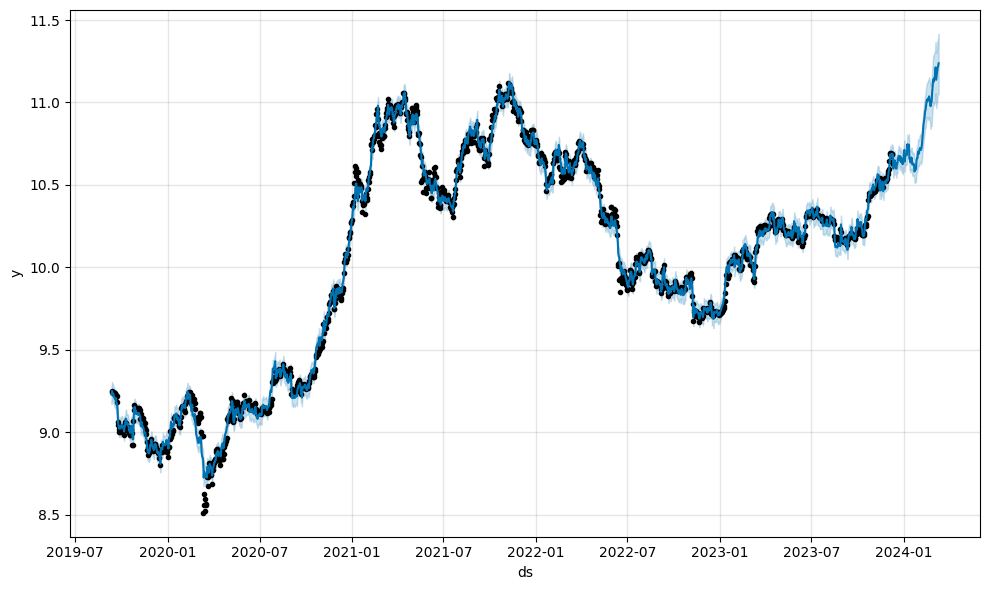

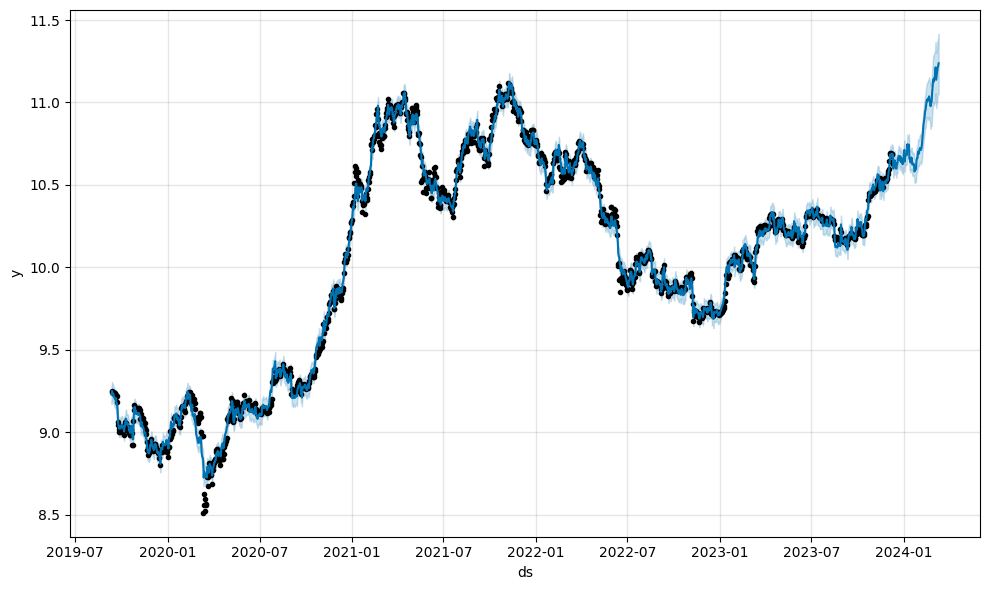

In [10]:
model_new.plot(forecast_data)

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

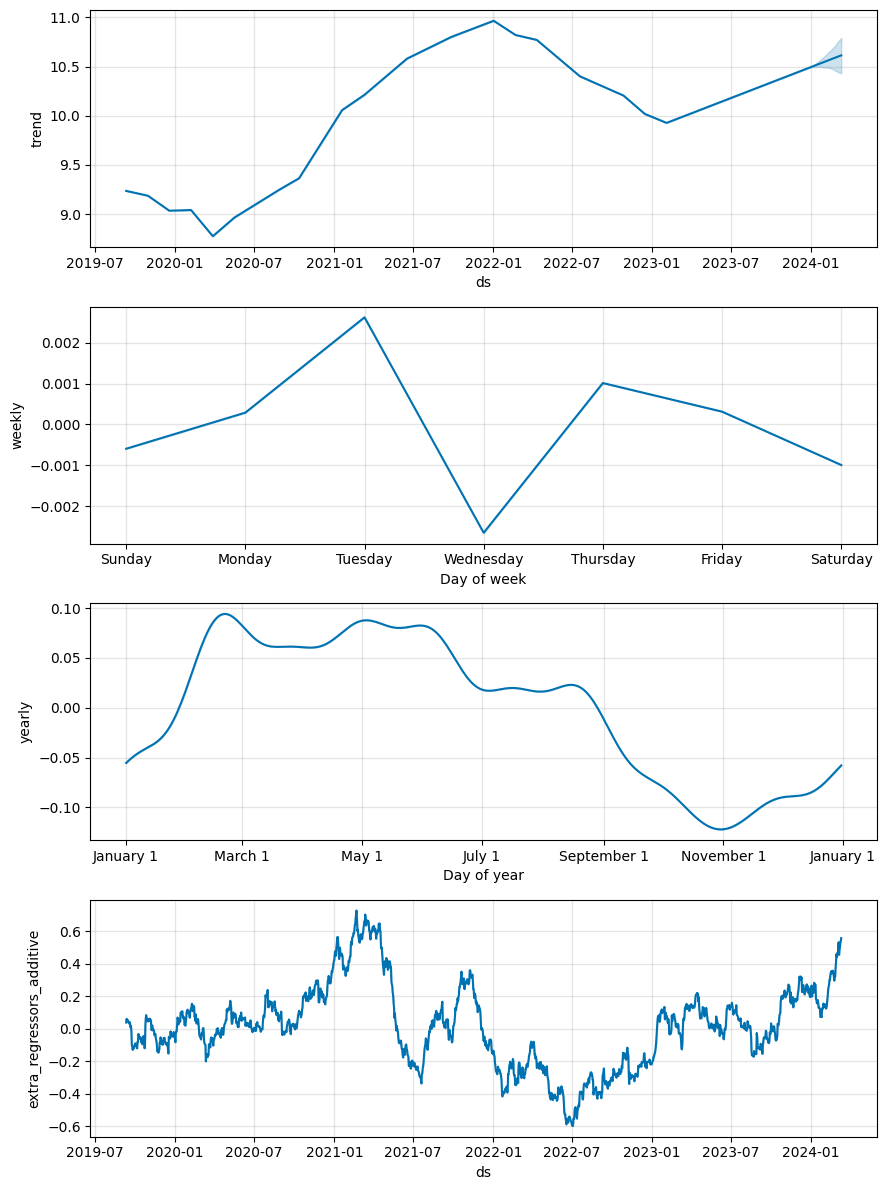

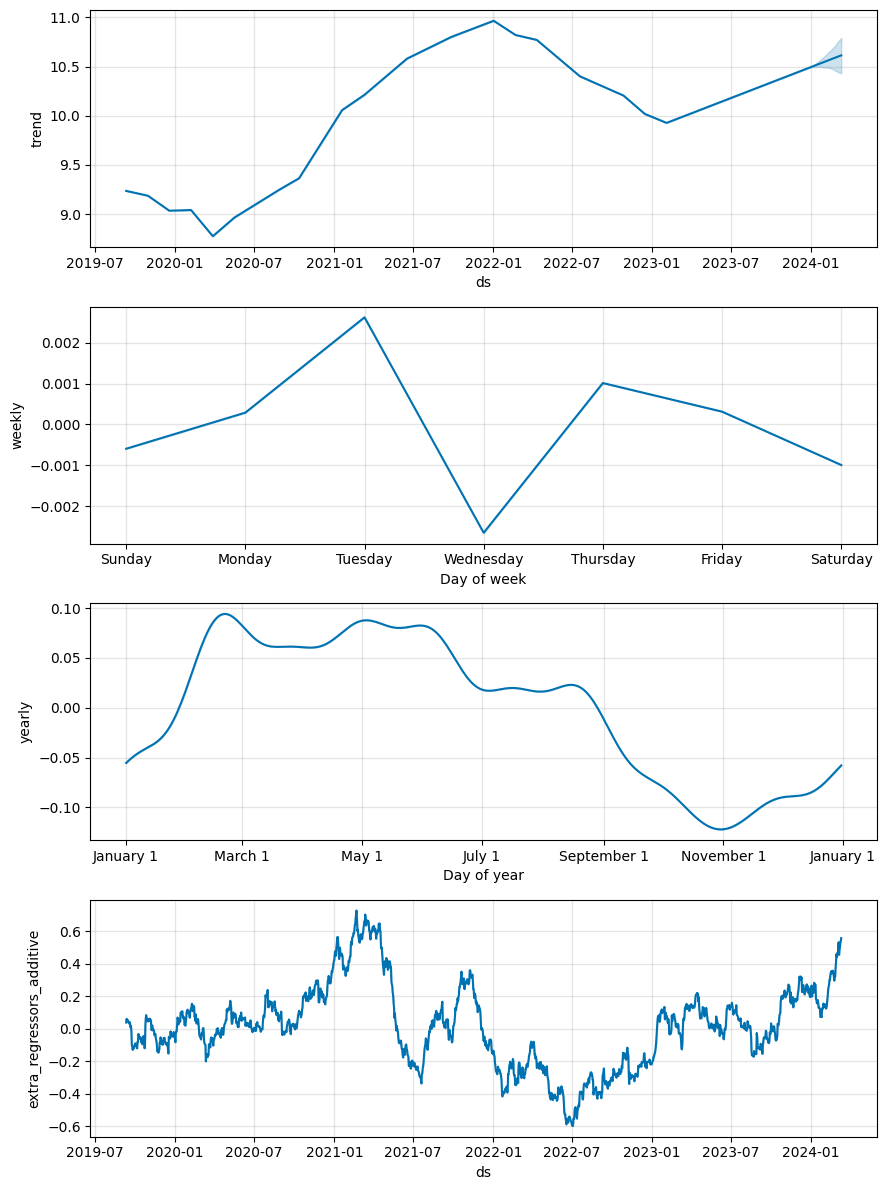

In [11]:
model_new.plot_components(forecast_data)

In [12]:
forecast_data_origin = forecast_data
forecast_data_origin['yhat']= np.exp(forecast_data_origin['yhat'])
forecast_data_origin['yhat_lower']= np.exp(forecast_data_origin['yhat_lower'])
forecast_data_origin['yhat_upper']= np.exp(forecast_data_origin['yhat_upper'])


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


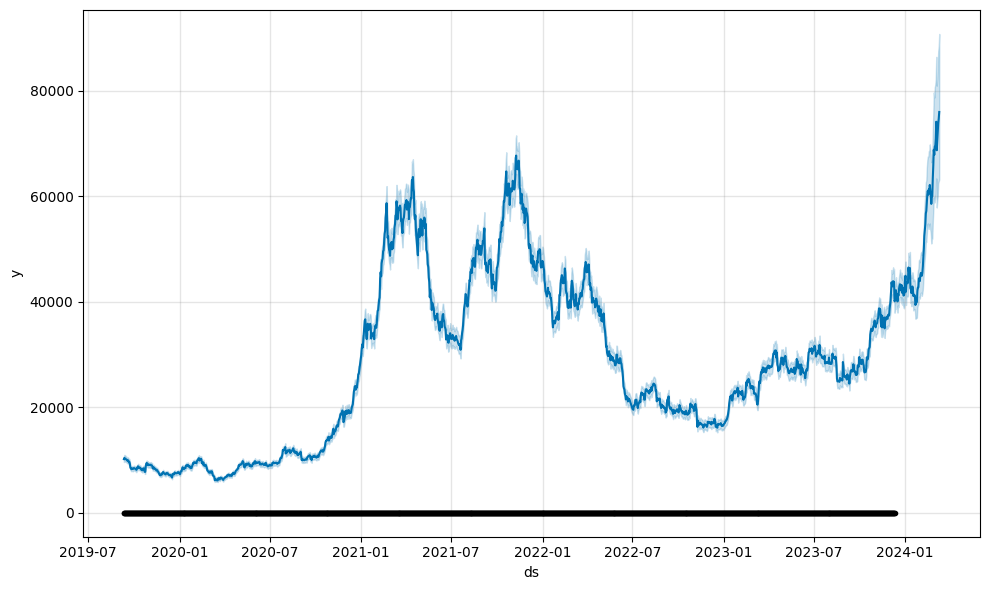

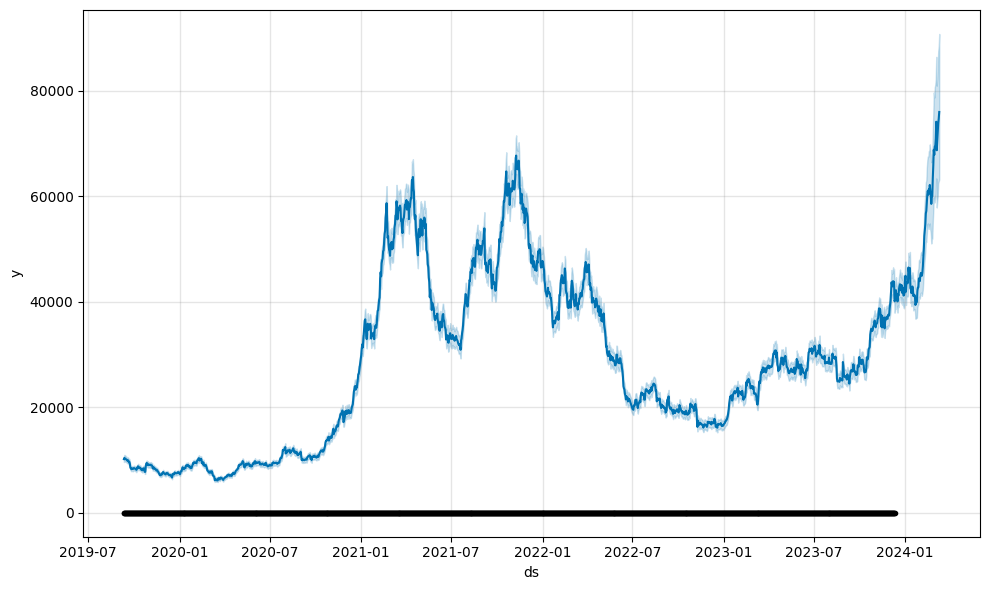

In [13]:
model_new.plot(forecast_data_origin)

In [14]:
df['y_log']=df['y'] #copy the log-transformed data to another column
df['y']=df['y_orig']

KeyError: 'y_orig'

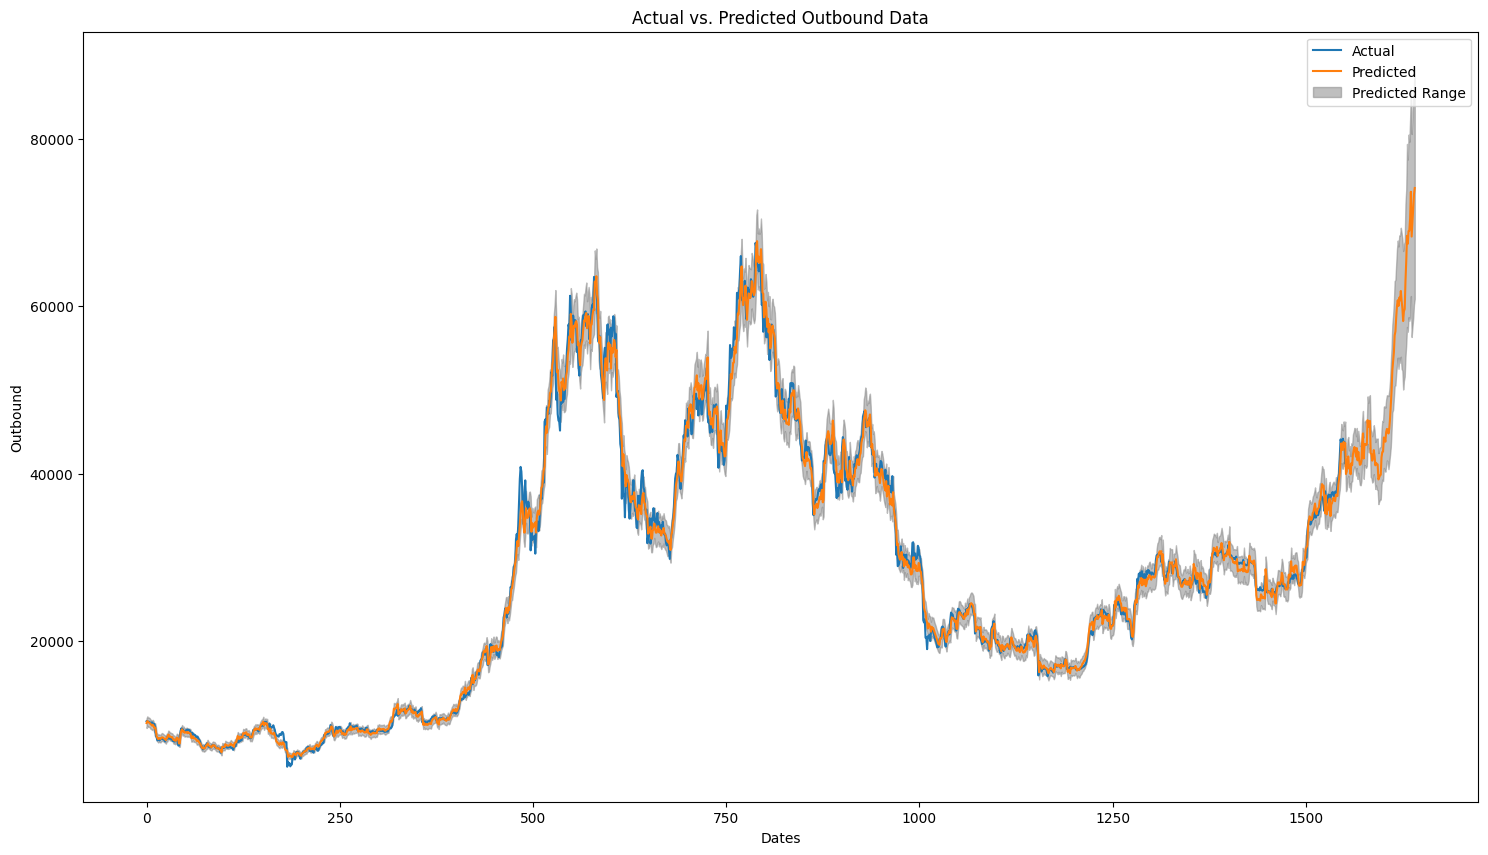

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
final_df = pd.DataFrame(forecast_data_origin)
# Assuming 'df' and 'final_df' are already defined DataFrames

# Plotting the predicted and actual line graph
plt.figure(figsize=(18, 10))
plt.plot(df_train.index, df_train["y_orig"], label='Actual')
plt.plot(final_df.index, final_df["yhat"], label='Predicted')
plt.fill_between(final_df.index, final_df["yhat_lower"], final_df["yhat_upper"], color='gray', alpha=0.5, label='Predicted Range')
plt.xlabel('Dates')
plt.ylabel('Outbound')
plt.title('Actual vs. Predicted Outbound Data')
plt.legend()
plt.show()


In [ ]:
df_test

,Open,High,Low,Adj Close,date,mean,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
1552,43792.019531,43808.375000,40234.578125,41243.832031,2023-12-11,0.0733,57.782997,40673.185075,34271.695522,32518.534017,211.488281,1,41450.222656
1553,41238.734375,42048.304688,40667.562500,41450.222656,2023-12-12,0.0209,58.568958,40747.188654,34413.844574,32636.834529,1422.277344,1,42890.742188
1554,41468.464844,43429.781250,40676.867188,42890.742188,2023-12-13,0.2413,63.632143,40951.336610,34581.703933,32772.647876,139.710938,1,43023.972656
1555,42884.261719,43390.859375,41767.089844,43023.972656,2023-12-14,0.2000,64.067289,41148.730519,34748.877571,32908.427012,-1098.492188,0,41929.757812
1556,43028.250000,43087.824219,41692.968750,41929.757812,2023-12-15,0.0885,57.964324,41223.114071,34891.073219,33027.914837,302.375000,1,42240.117188
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637,68341.054688,69170.625000,59323.910156,63801.199219,2024-03-05,-0.0089,69.675841,57282.619277,46364.610363,43126.577427,2330.753906,1,66106.804688
1638,63776.050781,67637.929688,62848.671875,66106.804688,2024-03-06,-0.0028,72.474246,58123.017888,46755.544904,43430.951298,825.742188,1,66925.484375
1639,66099.742188,68029.921875,65655.531250,66925.484375,2024-03-07,-0.0135,73.407860,58961.348029,47154.949646,43742.137166,1362.000000,1,68300.093750
1640,66938.093750,70083.054688,66230.453125,68300.093750,2024-03-08,0.0704,74.937140,59850.752384,47573.665371,44067.408114,199.625000,1,68498.882812


In [15]:
import plotly.graph_objs as go
import plotly.offline as py
#Plot predicted and actual line graph with X=dates, Y=Outbound
actual_chart = go.Scatter(y=df_train["y_orig"], name= 'Actual')
test_actual_chart = go.Scatter(y=df_test["TargetNextClose"], name= 'test_Actual', marker=dict(color='black'))
predict_chart = go.Scatter(y=final_df["yhat"], name= 'Predicted')
predict_chart_upper = go.Scatter(y=final_df["yhat_upper"], name= 'Predicted Upper')
predict_chart_lower = go.Scatter(y=final_df["yhat_lower"], name= 'Predicted Lower')
py.plot([actual_chart,test_actual_chart, predict_chart, predict_chart_upper, predict_chart_lower])

NameError: name 'final_df' is not defined

In [16]:
import models

In [17]:
models.cnn_lstm

<function models.cnn_lstm(df_scaled, X_train, y_train)>